# https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_self_rag_local/

In [ ]:
local_llm = "llama3"

In [5]:
from pprint import pprint
from typing import List

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain import hub
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.chat_models import ChatOllama
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_nomic.embeddings import NomicEmbeddings
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict

load_dotenv()

True

In [6]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)
retriever = vectorstore.as_retriever()

In [7]:
# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [8]:
### Generate

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOllama(model=local_llm, temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

According to the context, the design of generative agents combines LLM with memory, planning, and reflection mechanisms to enable agents to behave conditioned on past experience, as well as to interact with other agents. Additionally, a "Memory stream" is mentioned as a long-term memory module that records a comprehensive list of agents' experience in natural language.


In [9]:
### Hallucination Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [10]:
### Answer Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [11]:
### Question Re-writer

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Prompt
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the initial and formulate an improved question. \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'A great challenge!\n\nThe initial question "agent memory" is quite vague, so I\'ll try to rephrase it into a more specific and optimized query for vector-based retrieval.\n\nImproved question:\n"What are the key concepts related to an agent\'s cognitive abilities and how do they utilize their internal memory?"\n\nThis revised question:\n\n1. Adds context: By mentioning "cognitive abilities", we\'re providing more information about what kind of "memory" is being referred to, making it easier for the vector store to understand the query.\n2. Specifies relationships: The phrase "key concepts related to" helps the retrieval algorithm identify relevant documents that discuss the connections between an agent\'s cognitive abilities and their internal memory.\n3. Uses more precise language: Instead of a simple keyword like "memory", we\'re using more descriptive terms like "internal memory" to help the vector store retrieve documents that contain similar phrases.\n\nThis improved question sho

In [12]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [13]:
### Nodes


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [14]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

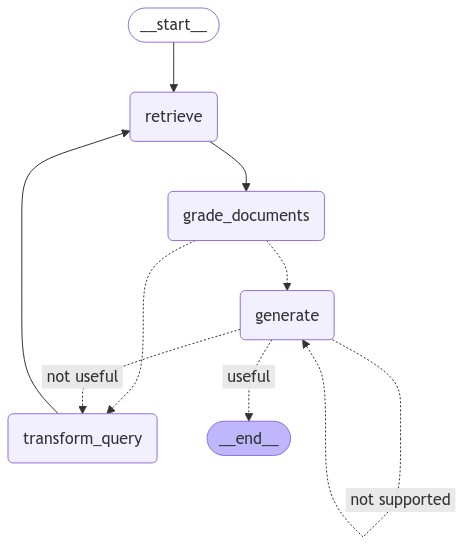

In [16]:
# Compile
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
# Run
inputs = {"question": "Explain how the different types of agent memory work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('According to the context, there are several types of memory mentioned, '
 'including Sensory Memory, which retains impressions of sensory information '
 'for up to a few seconds. Additionally, the concept of "Memory stream" is '
 "introduced as a long-term memory module that records agents' experience in "
 'natural language.')
